In [120]:
import pandas as pd
import numpy as np

from bisect import bisect 
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [121]:
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        if value <= 1-p:
            upper = bisect(cumsum,value+p)
            if not best or upper-i < best[1]-best[0]:
                best = (i,upper)
        else:
            break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])

# US Data (state level)

In [122]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
states = pd.read_csv(url,
                     usecols=[0,1,4],
                     index_col=['state', 'date'],
                     parse_dates=['date'],
                     squeeze=True).sort_index()

state_name = 'New York'
cases = states.xs(state_name).rename(f"{state_name} cases")

We can fit a Gompertz function to the cumulative death counts. s-shaped curves are not well for predicting out-of-sample in the long run. However, in the short run (e.g., 10 days) the predictions can be accurate. We can use this to project deaths for the next 14 days, which will give us an estimate for the number of cases today (assuming an IFR). Following we define functions for fitting and evaluating the performance out-of-sample

In [123]:
from scipy.optimize.minpack import curve_fit

def gompertz_curve(x,a,b,c):
    return c*np.exp(-b*np.exp(-x/a))

params = list(curve_fit(gompertz_curve, [i for i in range(1,len(cases)+1-14)], list(cases.values)[0:len(cases)-14], maxfev=6000)[0])

for d in range(len(cases)-14,len(cases)):
    print(list(cases.values)[d-1],gompertz_curve(d,params[0],params[1],params[2]))

3568 3593.8066495129833
4161 4274.571509738821
4758 5032.207266209503
5563 5867.025245528899
6268 6778.296900258752
7067 7764.28168217176
7844 8822.282718555009
8627 9948.725927158584
9385 11139.257651605565
10056 12388.85568939177
10834 13691.948671913586
11586 15042.539081720128
12192 16434.325693625044
12822 17860.821842237172


/Users/kpele/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


/Users/kpele/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


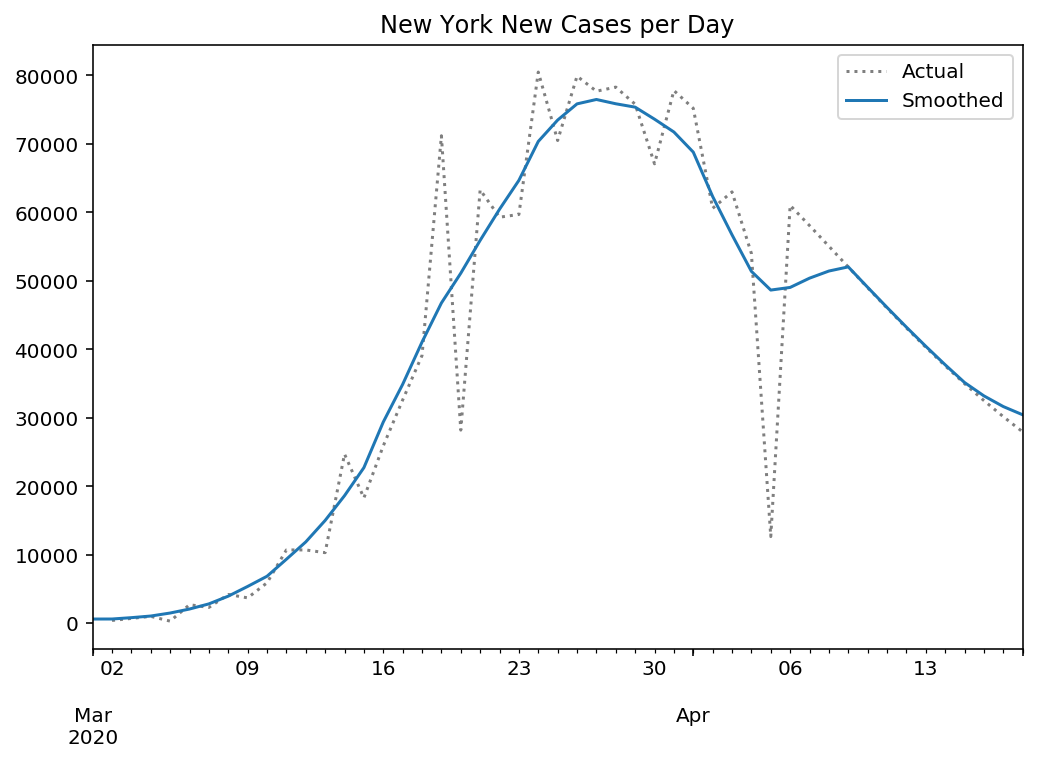

In [124]:
from datetime import datetime, timedelta

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

params = list(curve_fit(gompertz_curve, [i for i in range(1,len(cases)+1)], list(cases.values), maxfev=6000)[0])

# predict the deaths in the next 2 weeks with the gompertz
forecasted_deaths = [gompertz_curve(d,params[0],params[1],params[2]) for d in range(len(cases),len(cases)+14)]

current_day = cases.index[-1]
nindex = pd.date_range(start=current_day+timedelta(days=1),end=current_day+timedelta(days=14))
fdf = pd.Series(forecasted_deaths, index = nindex)

cases = cases.append(fdf)
IFR = 0.01

for i in range(14,len(cases)):
    cases[i-14] = cases[i]/IFR

cases = cases.drop(labels=pd.date_range(start=current_day+timedelta(days=1),end=current_day+timedelta(days=14)))
original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

In [125]:
def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

posteriors = get_posteriors(smoothed)

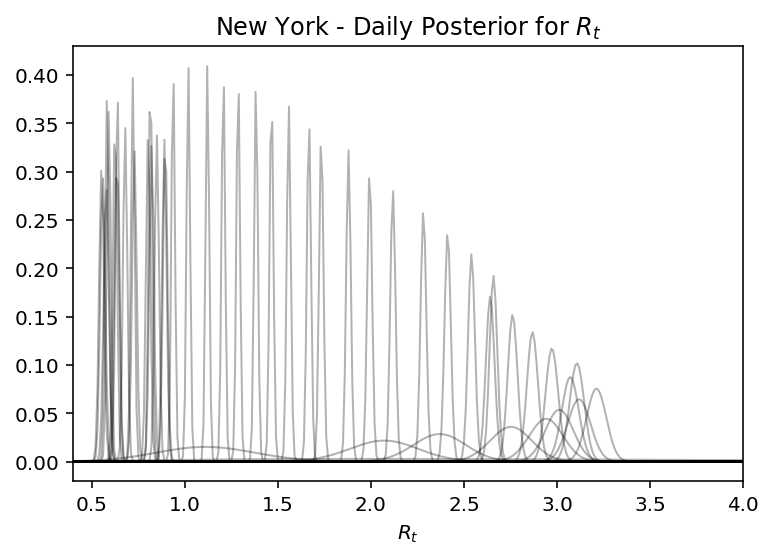

In [126]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

In [127]:
hdis = highest_density_interval(posteriors)
most_likely = posteriors.idxmax().rename('ML')

result = pd.concat([most_likely, hdis], axis=1)


In [128]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values(None)
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values(None)[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

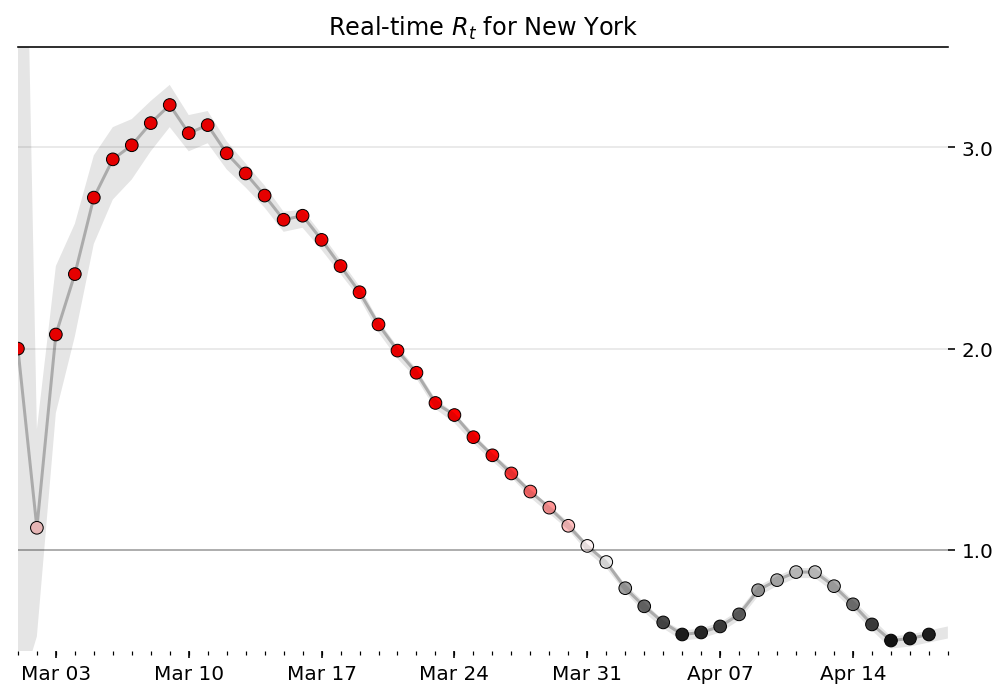

In [129]:
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.set_ylim(.5,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))